<a href="https://colab.research.google.com/github/shahma123/codsoft/blob/main/movie_rating/%20movie_rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()
csv_fname = list(uploaded.keys())[0]
print("Uploaded file:", csv_fname)


Saving IMDb Movies India.csv to IMDb Movies India (1).csv
Uploaded file: IMDb Movies India (1).csv


Loaded dataset shape: (15509, 10)
Columns: ['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


Using target column: Rating
count    7919.000000
mean        5.841621
std         1.381777
min         1.100000
25%         4.900000
50%         6.000000
75%         6.800000
max        10.000000
Name: Rating, dtype: float64
Selected features: ['Year', 'Duration', 'Votes', 'Genre_simple']


,Year,Duration,Votes,Genre_simple
0,NaN,NaN,NaN,Drama
1,2019.0,109.0,8.0,Drama
2,2021.0,90.0,NaN,Drama
3,2019.0,110.0,35.0,Comedy
4,2010.0,105.0,NaN,Drama


Numeric features: ['Year', 'Duration', 'Votes']
Categorical features: ['Genre_simple']
Train/test shapes: (6335, 4) (1584, 4)
RMSE: 1.1661, MAE: 0.8767, R2: 0.2686
Saved model and processed CSV to movie_rating_outputs


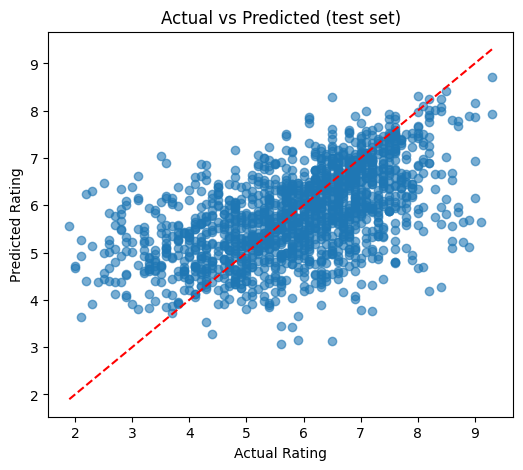

,actual,predicted
9456,3.3,3.835710
14816,5.3,5.286000
3213,5.7,5.918000
3778,7.2,3.764000
5775,3.5,5.408000
12203,7.2,5.334000
12305,3.8,5.555333
4650,6.9,6.838000
8701,5.2,5.107667
4707,7.4,6.038000


In [6]:
import os, math
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import re


csv_path = "IMDb Movies India.csv"

try:
    df = pd.read_csv(csv_path, encoding='utf-8', low_memory=False)
except Exception:
    df = pd.read_csv(csv_path, encoding='latin1', low_memory=False)

print("Loaded dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

possible_target_cols = [c for c in df.columns if 'rating' in c.lower() or 'score' in c.lower() or 'vote' in c.lower()]
if possible_target_cols:
    target = possible_target_cols[0]
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise RuntimeError("No numeric columns found. Please tell me which column is the rating/target.")
    target = numeric_cols[0]

print("Using target column:", target)
print(df[target].describe())

def clean_and_coerce_numeric(series):
    cleaned = series.astype(str).str.replace(r'[^\d\.\-]', '', regex=True)
    cleaned = cleaned.replace('', np.nan)
    return pd.to_numeric(cleaned, errors='coerce')


for col in ['Year', 'Duration', 'Votes', 'Runtime', 'Budget']:
    if col in df.columns:
        df[col] = clean_and_coerce_numeric(df[col])

if 'Genre' in df.columns:
    df['Genre_simple'] = df['Genre'].astype(str).apply(lambda s: s.split('|')[0].split(',')[0].strip() if pd.notnull(s) else s)
    genre_col = 'Genre_simple'
else:
    genre_col = None

feature_candidates = []
for c in ['Year', 'Duration', 'Votes', 'Runtime', 'Budget', genre_col]:
    if c and c in df.columns:
        feature_candidates.append(c)

if not feature_candidates:
    feature_candidates = [c for c in df.columns if c != target][:6]

print("Selected features:", feature_candidates)
display(df[feature_candidates].head())


data = df[feature_candidates + [target]].copy()
data = data.dropna(subset=[target])
X = data[feature_candidates]
y = data[target]

numeric_features = [c for c in feature_candidates if np.issubdtype(X[c].dtype, np.number)]
categorical_features = [c for c in feature_candidates if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

try:
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except TypeError:

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=1))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train/test shapes:", X_train.shape, X_test.shape)
model_pipeline.fit(X_train, y_train)


y_pred = model_pipeline.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


out_folder = "movie_rating_outputs"
os.makedirs(out_folder, exist_ok=True)
joblib.dump(model_pipeline, os.path.join(out_folder, "movie_rating_model_colab.pkl"))
data.to_csv(os.path.join(out_folder, "movie_rating_processed_colab.csv"), index=False)
print("Saved model and processed CSV to", out_folder)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_test, y_pred, alpha=0.6)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_xlabel("Actual Rating")
ax.set_ylabel("Predicted Rating")
ax.set_title("Actual vs Predicted (test set)")
plt.show()

display(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head(12))